## Definindo o Problema

In [347]:
#!pip install lightgbm;
#!pip install pymoo;
#!pip install -U pyrecorder;

In [348]:
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from yellowbrick.classifier import ConfusionMatrix
import numpy as np
from tqdm.notebook import tqdm as tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold
#from google.colab import drive
import pickle
from pymoo.algorithms.soo.nonconvex.pso import PSO, PSOAnimation
#from pymoo.factory import Rastrigin
from pymoo.optimize import minimize
import matplotlib.pyplot as plt
from pymoo.factory import get_termination
#from pymoo.util.display import Display
from pymoo.core.callback import Callback

In [349]:
import lightgbm as lgb

In [350]:
#drive.mount('/content/gdrive')

In [351]:
#with open('/content/gdrive/MyDrive/datasets/credit.pkl', 'rb') as f:
#    x_credit_train, x_credit_test, y_credit_train, y_credit_test = pickle.load(f)
    
with open('./credit.pkl', 'rb') as f:
    x_credit_train, x_credit_test, y_credit_train, y_credit_test = pickle.load(f)

In [352]:

x_credit = np.concatenate((x_credit_train, x_credit_test), axis = 0)
y_credit = np.concatenate((y_credit_train, y_credit_test), axis = 0)


Definindo as restrições 

In [353]:
OBJECTIVE = ['Accuracy']
DIMENSIONS = 9 #num_leaves, min_child_samples, n_estimators, learning_rate, subsample_for_bin, min_split_gain, min_child_weight, subsample, reg_alpha, reg_lambda
ITERATIONS = 10
POPULATION = 15
num_leaves_min = 10
num_leaves_max = 200
min_child_samples_min = 10
min_child_samples_max = 50
n_estimators_min = 20
n_estimators_max = 1000

learning_rate_min = 0.001
learning_rate_max = 0.5
subsample_for_bin_min = 50000
subsample_for_bin_max = 500000
min_split_gain_min = 0.01
min_split_gain_max = 0.5
min_child_weight_min = 0.001
min_child_weight_max = 0.15
subsample_min = 1.0
subsample_max = 2.0
reg_alpha_min =0.01
reg_alpha_max = 100.0 
reg_lambda_min = 0.01
reg_lambda_max = 100.0

BOUNDS = []
SEED = 1
INDIVIDUALS = []

Definindo o problema

In [354]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem

class OptimizeWithAccuracy(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var= DIMENSIONS,
                         n_obj=1,
                         n_constr=9,
                         xl=np.array([num_leaves_min, min_child_samples_min, n_estimators_min, learning_rate_min, subsample_for_bin_min,
                                      min_split_gain_min, min_child_weight_min, reg_alpha_min, reg_lambda_min]),
                         xu=np.array([num_leaves_max, min_child_samples_max, n_estimators_max, learning_rate_max, subsample_for_bin_max,
                                      min_split_gain_max, min_child_weight_max, reg_alpha_max, reg_lambda_max])
                        )

    def _evaluate(self, x, out, *args, **kwargs):
        #num_leaves, min_child_samples, n_estimators, learning_rate, subsample_for_bin, min_split_gain, min_child_weight, reg_alpha, reg_lambda
        
        model_lgb = lgb.LGBMClassifier(num_leaves        = int(np.floor(x[0])), 
                                       min_child_samples = int(np.floor(x[1])), 
                                       n_estimators      = int(np.floor(x[2])),
                                       learning_rate     = x[3] ,
                                       subsample_for_bin = int(np.floor(x[4])),
                                       min_split_gain    = x[5],
                                       min_child_weight  = x[6],
                                       reg_alpha         = x[7],
                                       reg_lambda        = x[8],
                                       max_depth=- 1,
                                       n_jobs = -1
                                       )
        
        kfold = KFold(n_splits = 3, shuffle = True)
        
        scores = cross_val_score(model_lgb, x_credit, y_credit, cv = kfold, n_jobs=-1)  
        
        result = scores.mean()
        out['F'] = -1 * result

problemAccuracy = OptimizeWithAccuracy()

In [355]:
class OptimizeWithF1(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var= DIMENSIONS,
                         n_obj=1,
                         n_constr=9,
                         xl=np.array([num_leaves_min, min_child_samples_min, n_estimators_min, learning_rate_min, subsample_for_bin_min,
                                      min_split_gain_min, min_child_weight_min, reg_alpha_min, reg_lambda_min]),
                         xu=np.array([num_leaves_max, min_child_samples_max, n_estimators_max, learning_rate_max, subsample_for_bin_max,
                                      min_split_gain_max, min_child_weight_max, reg_alpha_max, reg_lambda_max])
                        )

    def _evaluate(self, x, out, *args, **kwargs):
        #num_leaves, min_child_samples, n_estimators, learning_rate, subsample_for_bin, min_split_gain, min_child_weight, reg_alpha, reg_lambda
        
        model_lgb = lgb.LGBMClassifier(num_leaves        = int(np.round(x[0])), 
                                       min_child_samples = int(np.round(x[1])), 
                                       n_estimators      = int(np.round(x[2])),
                                       learning_rate     = x[3] ,
                                       subsample_for_bin = int(np.round(x[4])),
                                       min_split_gain    = x[5],
                                       min_child_weight  = x[6],
                                       reg_alpha         = x[7],
                                       reg_lambda        = x[8],
                                       max_depth=- 1,
                                       n_jobs = -1
                                       )
        
        kfold = KFold(n_splits = 3, shuffle = True)
        
        scores = cross_val_score(model_lgb, x_credit, y_credit, cv = kfold, scoring='f1', n_jobs=-1)  
        
        result = scores.mean()
        out['F'] = -1 * result

problemF1 = OptimizeWithF1()

In [356]:
class OptimizeWithAUC(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var= DIMENSIONS,
                         n_obj=1,
                         n_constr=9,
                         xl=np.array([num_leaves_min, min_child_samples_min, n_estimators_min, learning_rate_min, subsample_for_bin_min,
                                      min_split_gain_min, min_child_weight_min, reg_alpha_min, reg_lambda_min]),
                         xu=np.array([num_leaves_max, min_child_samples_max, n_estimators_max, learning_rate_max, subsample_for_bin_max,
                                      min_split_gain_max, min_child_weight_max, reg_alpha_max, reg_lambda_max])
                        )

    def _evaluate(self, x, out, *args, **kwargs):
        #num_leaves, min_child_samples, n_estimators, learning_rate, subsample_for_bin, min_split_gain, min_child_weight, reg_alpha, reg_lambda
        
        model_lgb = lgb.LGBMClassifier(num_leaves        = int(np.round(x[0])), 
                                       min_child_samples = int(np.round(x[1])), 
                                       n_estimators      = int(np.round(x[2])),
                                       learning_rate     = x[3] ,
                                       subsample_for_bin = int(np.round(x[4])),
                                       min_split_gain    = x[5],
                                       min_child_weight  = x[6],
                                       reg_alpha         = x[7],
                                       reg_lambda        = x[8],
                                       max_depth=- 1,
                                       n_jobs = -1
                                       )
        
        kfold = KFold(n_splits = 3, shuffle = True)
        
        scores = cross_val_score(model_lgb, x_credit, y_credit, cv = kfold, scoring='roc_auc', n_jobs=-1)  
        
        result = scores.mean()
        out['F'] = -1 * result

problemAUC = OptimizeWithAUC()

In [357]:
from pymoo.util.display.column import Column
from pymoo.util.display.output import Output

In [358]:
class MyOutput(Output):

    def __init__(self):
        super().__init__()
        global pbar 
        pbar = tqdm(total=ITERATIONS)
        self.score = Column("score", width=13)
        self.Parameters = Column("Parameters", width=35)
        self.columns += [self.score, self.Parameters]

    def update(self, algorithm):
        super().update(algorithm)
        self.score.set(-np.min(algorithm.pop.get("F")))
        #self.Parameters.set(algorithm.pop.get("X")[0])
        pbar.update(1)
        if pbar.n == ITERATIONS: pbar.close()

## Particle Swarm Optimization (PSO)

### Acurácia

In [359]:
ITERATIONS = 32
POPULATION = 32

In [360]:
algorithm = PSO(#pop_size=POPULATION, 
                #w=0.3, c1=4.0, c2=1.0, 
                #adaptive=False, initial_velocity='random', 
                #max_velocity_rate=0.75, pertube_best=False,
                max_velocity_rate=0.25,
                pop_size=POPULATION)
term = get_termination("n_gen", ITERATIONS)

res = minimize(problemAccuracy,
               algorithm,
               #seed=SEED,
               save_history=True,
               verbose=True,
               output=MyOutput(),
               termination = term)


index_best_individual = np.where(res.pop.get('F') == np.min(res.pop.get('F')))[0][0]
score_best_individual = res.pop.get('F')[index_best_individual]
parameters_best_individual = res.pop.get('X')[index_best_individual]

print(f'Best Accuracy Score {-score_best_individual}')
print(f'Model parameters: \n {parameters_best_individual}')

C:\Users\Felps\AppData\Local\Temp\ipykernel_13696\2417788545.py:7: DeprecationWarning: Call to deprecated function (or staticmethod) get_termination. (Please use `from pymoo.termination import get_termination`)
  term = get_termination("n_gen", ITERATIONS)


  0%|          | 0/32 [00:00<?, ?it/s]

n_gen  |  n_eval  |     score     |              Parameters            
     1 |       32 |  0.8410117067 |                                   -
     2 |       64 |  0.8410117067 |                                   -
     3 |       96 |  0.8410117067 |                                   -
     4 |      128 |  0.8410117067 |                                   -
     5 |      160 |  0.8410117067 |                                   -
     6 |      192 |  0.8410117067 |                                   -
     7 |      224 |  0.8410117067 |                                   -
     8 |      256 |  0.8410117067 |                                   -
     9 |      288 |  0.8410117067 |                                   -
    10 |      320 |  0.8410117067 |                                   -
    11 |      352 |  0.8410117067 |                                   -
    12 |      384 |  0.8410117067 |                                   -
    13 |      416 |  0.8410117067 |                             

In [361]:
final_model = lgb.LGBMClassifier(num_leaves       = int(np.floor(parameters_best_individual[0])), 
                                min_child_samples = int(np.floor(parameters_best_individual[1])), 
                                n_estimators      = int(np.floor(parameters_best_individual[2])),
                                learning_rate     = parameters_best_individual[3] ,
                                subsample_for_bin = int(np.floor(parameters_best_individual[4])),
                                min_split_gain    = parameters_best_individual[5],
                                min_child_weight  = parameters_best_individual[6],
                                reg_alpha         = parameters_best_individual[7],
                                reg_lambda        = parameters_best_individual[8],
                                max_depth=- 1
                                )


kfold = KFold(n_splits = 3, shuffle = True)

scores = cross_val_score(final_model, x_credit, y_credit, cv = kfold, n_jobs=-1)  

result = scores.mean()
#print(result)

In [362]:
trlist = np.array([])
for i in range(len(res.history)):
  trlist = np.append(trlist, -res.history[i].pop.get('F').reshape(-1)) 

In [363]:
scorelist = []

for i in range(len(trlist)):
#for i in range(1):
  if i == 0:
    scorelist.append(trlist[i])
  elif trlist[i] > scorelist[i-1]:
    scorelist.append(trlist[i])
  else:
    scorelist.append(scorelist[i-1])

In [364]:
Accuracy_PSO = scorelist

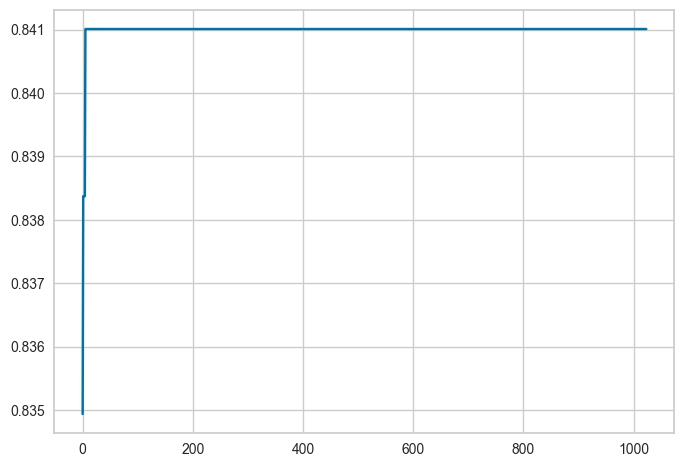

In [365]:
plt.plot(Accuracy_PSO);

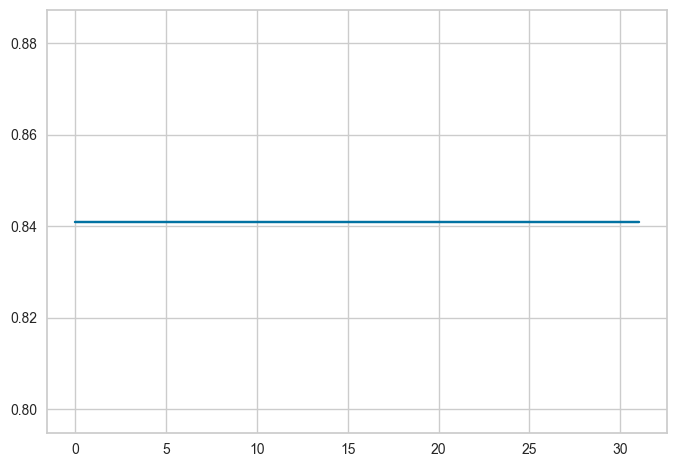

In [366]:
tracking = [-np.min(individual.pop.get('F')) for individual in res.history ]
tracking_PSO_Accuracy = tracking
plt.plot(tracking)

### F1 Score 

In [367]:
algorithm = PSO(#pop_size=POPULATION, 
                #w=0.3, c1=4.0, c2=1.0, 
                #adaptive=False, initial_velocity='random', 
                #max_velocity_rate=0.75, pertube_best=False,
                max_velocity_rate=0.25,
                pop_size=POPULATION)
term = get_termination("n_gen", ITERATIONS)

res = minimize(problemF1,
               algorithm,
               #seed=SEED,
               save_history=True,
               verbose=True,
               output=MyOutput(),
               termination = term)


index_best_individual = np.where(res.pop.get('F') == np.min(res.pop.get('F')))[0][0]
score_best_individual = res.pop.get('F')[index_best_individual]
parameters_best_individual = res.pop.get('X')[index_best_individual]

print(f'Best F1 Score {-score_best_individual}')
print(f'Model parameters: \n {parameters_best_individual}')

C:\Users\Felps\AppData\Local\Temp\ipykernel_13696\2645485919.py:7: DeprecationWarning: Call to deprecated function (or staticmethod) get_termination. (Please use `from pymoo.termination import get_termination`)
  term = get_termination("n_gen", ITERATIONS)


  0%|          | 0/32 [00:00<?, ?it/s]

n_gen  |  n_eval  |     score     |              Parameters            
     1 |       32 |  0.5478841336 |                                   -
     2 |       64 |  0.5478841336 |                                   -
     3 |       96 |  0.5478841336 |                                   -
     4 |      128 |  0.5478841336 |                                   -
     5 |      160 |  0.5478841336 |                                   -
     6 |      192 |  0.5478841336 |                                   -
     7 |      224 |  0.5478841336 |                                   -
     8 |      256 |  0.5478841336 |                                   -
     9 |      288 |  0.5478841336 |                                   -
    10 |      320 |  0.5478841336 |                                   -
    11 |      352 |  0.5478841336 |                                   -
    12 |      384 |  0.5478841336 |                                   -
    13 |      416 |  0.5478841336 |                             

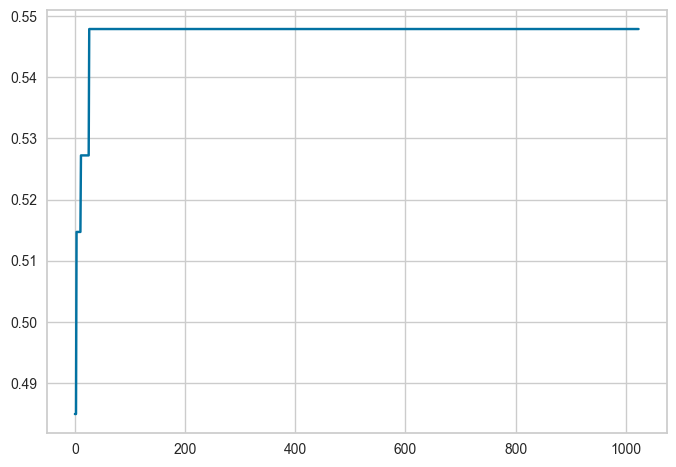

In [368]:
trlist = np.array([])
for i in range(len(res.history)):
  trlist = np.append(trlist, -res.history[i].pop.get('F').reshape(-1)) 
  
scorelist = []

for i in range(len(trlist)):
#for i in range(1):
  if i == 0:
    scorelist.append(trlist[i])
  elif trlist[i] > scorelist[i-1]:
    scorelist.append(trlist[i])
  else:
    scorelist.append(scorelist[i-1])
    
F1_PSO = scorelist

plt.plot(scorelist);

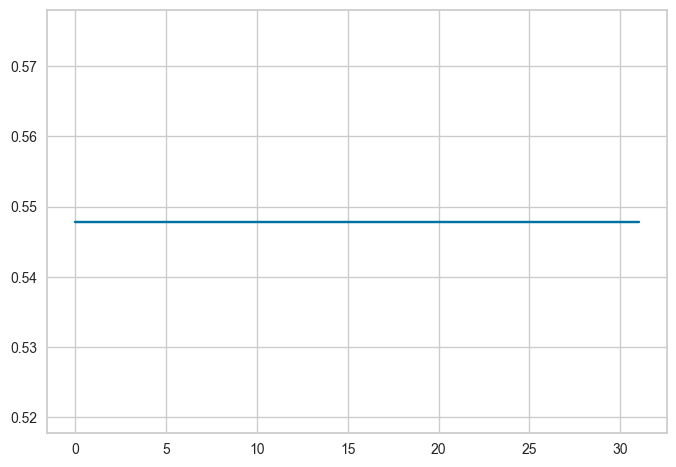

In [369]:
tracking = [-np.min(individual.pop.get('F')) for individual in res.history ]
tracking_PSO_F1 = tracking
plt.plot(tracking)

### AUC

In [370]:
algorithm = PSO(#pop_size=POPULATION, 
                #w=0.3, c1=4.0, c2=1.0, 
                #adaptive=False, initial_velocity='random', 
                #max_velocity_rate=0.75, pertube_best=False,
                max_velocity_rate=0.25,
                pop_size=POPULATION)
term = get_termination("n_gen", ITERATIONS)

res = minimize(problemAUC,
               algorithm,
               #seed=SEED,
               save_history=True,
               verbose=True,
               output=MyOutput(),
               termination = term)


index_best_individual = np.where(res.pop.get('F') == np.min(res.pop.get('F')))[0][0]
score_best_individual = res.pop.get('F')[index_best_individual]
parameters_best_individual = res.pop.get('X')[index_best_individual]

print(f'Best AUC Score {-score_best_individual}')
print(f'Model parameters: \n {parameters_best_individual}')

C:\Users\Felps\AppData\Local\Temp\ipykernel_13696\4093374697.py:7: DeprecationWarning: Call to deprecated function (or staticmethod) get_termination. (Please use `from pymoo.termination import get_termination`)
  term = get_termination("n_gen", ITERATIONS)


  0%|          | 0/32 [00:00<?, ?it/s]

n_gen  |  n_eval  |     score     |              Parameters            
     1 |       32 |  0.8382579611 |                                   -
     2 |       64 |  0.8382579611 |                                   -
     3 |       96 |  0.8382579611 |                                   -
     4 |      128 |  0.8382579611 |                                   -
     5 |      160 |  0.8382579611 |                                   -
     6 |      192 |  0.8382579611 |                                   -
     7 |      224 |  0.8382579611 |                                   -
     8 |      256 |  0.8382579611 |                                   -
     9 |      288 |  0.8382579611 |                                   -
    10 |      320 |  0.8382579611 |                                   -
    11 |      352 |  0.8382579611 |                                   -
    12 |      384 |  0.8382579611 |                                   -
    13 |      416 |  0.8382579611 |                             

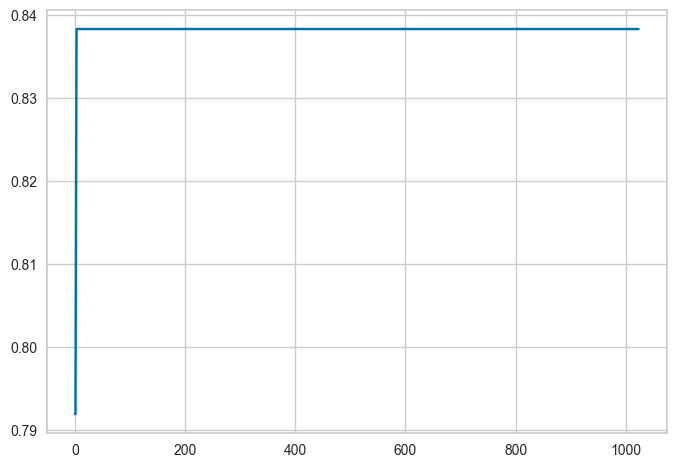

In [371]:
trlist = np.array([])
for i in range(len(res.history)):
  trlist = np.append(trlist, -res.history[i].pop.get('F').reshape(-1)) 
  
scorelist = []

for i in range(len(trlist)):
#for i in range(1):
  if i == 0:
    scorelist.append(trlist[i])
  elif trlist[i] > scorelist[i-1]:
    scorelist.append(trlist[i])
  else:
    scorelist.append(scorelist[i-1])
    
AUC_PSO = scorelist

plt.plot(scorelist);

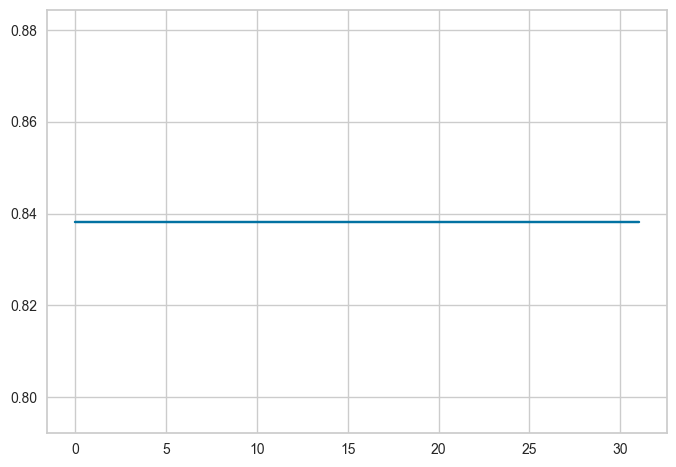

In [372]:
tracking = [-np.min(individual.pop.get('F')) for individual in res.history ]
tracking_PSO_AUC = tracking
plt.plot(tracking)

## Algoritmo Genético (GA)

### Acurácia

In [373]:
ITERATIONS = 32
POPULATION = 32

In [374]:
from pymoo.algorithms.soo.nonconvex.ga import GA

algorithm = GA(pop_size=POPULATION)

term = get_termination("n_gen", ITERATIONS)

res = minimize(problemAccuracy,
               algorithm,
               save_history=True,
               verbose=True,
               output=MyOutput(),
               termination = term)


index_best_individual = np.where(res.pop.get('F') == np.min(res.pop.get('F')))[0][0]
score_best_individual = res.pop.get('F')[index_best_individual]
parameters_best_individual = res.pop.get('X')[index_best_individual]

print(f'Best Accuracy Score {-score_best_individual}')
print(f'Model parameters: \n {parameters_best_individual}')

C:\Users\Felps\AppData\Local\Temp\ipykernel_13696\3390466977.py:5: DeprecationWarning: Call to deprecated function (or staticmethod) get_termination. (Please use `from pymoo.termination import get_termination`)
  term = get_termination("n_gen", ITERATIONS)


  0%|          | 0/32 [00:00<?, ?it/s]

n_gen  |  n_eval  |     score     |              Parameters            
     1 |       32 |  0.8394154998 |                                   -
     2 |       64 |  0.8394154998 |                                   -
     3 |       96 |  0.8405513411 |                                   -
     4 |      128 |  0.8405818680 |                                   -
     5 |      160 |  0.8409502317 |                                   -
     6 |      192 |  0.8409810215 |                                   -
     7 |      224 |  0.8417483775 |                                   -
     8 |      256 |  0.8417483775 |                                   -
     9 |      288 |  0.8418711522 |                                   -
    10 |      320 |  0.8431293556 |                                   -
    11 |      352 |  0.8431293556 |                                   -
    12 |      384 |  0.8431293556 |                                   -
    13 |      416 |  0.8431293556 |                             

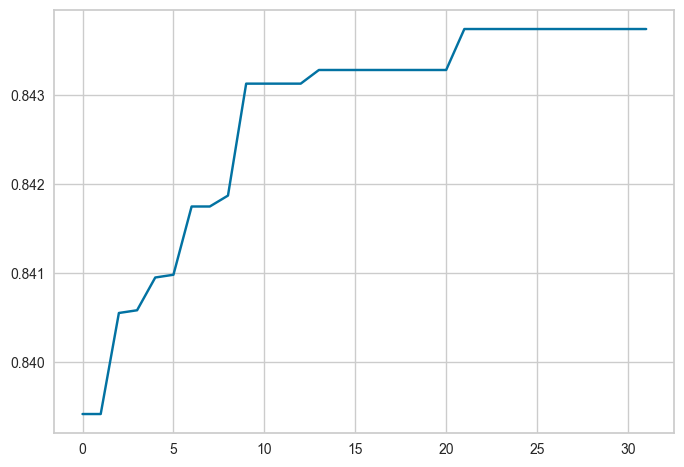

In [375]:
tracking = [-np.min(individual.pop.get('F')) for individual in res.history ]
tracking_GA_Accuracy = tracking
plt.plot(tracking)

In [376]:
trlist = np.array([])
for i in range(len(res.history)):
  trlist = np.append(trlist, -res.history[i].pop.get('F').reshape(-1)) 

In [377]:
scorelist = []

for i in range(len(trlist)):
  if i == 0:
    scorelist.append(trlist[i])
  elif trlist[i] > scorelist[i-1]:
    scorelist.append(trlist[i])
  else:
    scorelist.append(scorelist[i-1])

In [378]:
Accuracy_GA = scorelist

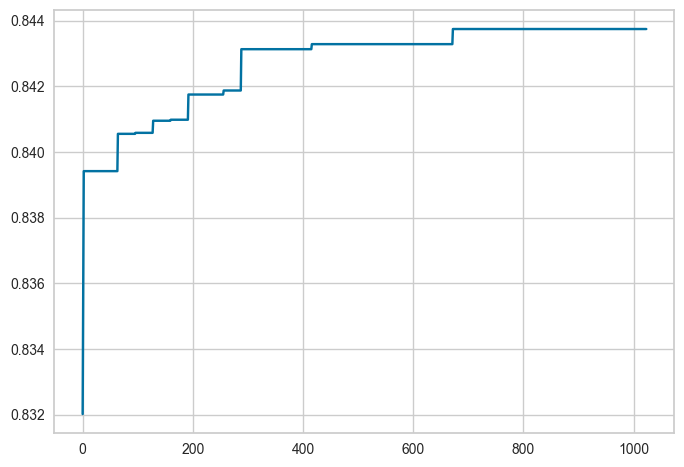

In [379]:
plt.plot(scorelist);

### F1 Score 

In [380]:
from pymoo.algorithms.soo.nonconvex.ga import GA

algorithm = GA(pop_size=POPULATION)

term = get_termination("n_gen", ITERATIONS)

res = minimize(problemF1,
               algorithm,
               save_history=True,
               verbose=True,
               output=MyOutput(),
               termination = term)


index_best_individual = np.where(res.pop.get('F') == np.min(res.pop.get('F')))[0][0]
score_best_individual = res.pop.get('F')[index_best_individual]
parameters_best_individual = res.pop.get('X')[index_best_individual]

print(f'Best F1 Score {-score_best_individual}')
print(f'Model parameters: \n {parameters_best_individual}')

C:\Users\Felps\AppData\Local\Temp\ipykernel_13696\1745594656.py:5: DeprecationWarning: Call to deprecated function (or staticmethod) get_termination. (Please use `from pymoo.termination import get_termination`)
  term = get_termination("n_gen", ITERATIONS)


  0%|          | 0/32 [00:00<?, ?it/s]

n_gen  |  n_eval  |     score     |              Parameters            
     1 |       32 |  0.5582819984 |                                   -
     2 |       64 |  0.5582819984 |                                   -
     3 |       96 |  0.5582819984 |                                   -
     4 |      128 |  0.5611743976 |                                   -
     5 |      160 |  0.5611743976 |                                   -
     6 |      192 |  0.5620141955 |                                   -
     7 |      224 |  0.5639618482 |                                   -
     8 |      256 |  0.5639618482 |                                   -
     9 |      288 |  0.5662779871 |                                   -
    10 |      320 |  0.5686952487 |                                   -
    11 |      352 |  0.5686952487 |                                   -
    12 |      384 |  0.5718870509 |                                   -
    13 |      416 |  0.5718870509 |                             

In [ ]:
trlist = np.array([])
for i in range(len(res.history)):
  trlist = np.append(trlist, -res.history[i].pop.get('F').reshape(-1)) 
  
scorelist = []

for i in range(len(trlist)):
#for i in range(1):
  if i == 0:
    scorelist.append(trlist[i])
  elif trlist[i] > scorelist[i-1]:
    scorelist.append(trlist[i])
  else:
    scorelist.append(scorelist[i-1])
    
F1_GA = scorelist

plt.plot(scorelist);

In [ ]:
tracking = [-np.min(individual.pop.get('F')) for individual in res.history ]
tracking_GA_F1 = tracking
plt.plot(tracking)

### AUC

In [ ]:
from pymoo.algorithms.soo.nonconvex.ga import GA

algorithm = GA(pop_size=POPULATION)

term = get_termination("n_gen", ITERATIONS)

res = minimize(problemAUC,
               algorithm,
               save_history=True,
               verbose=True,
               output=MyOutput(),
               termination = term)


index_best_individual = np.where(res.pop.get('F') == np.min(res.pop.get('F')))[0][0]
score_best_individual = res.pop.get('F')[index_best_individual]
parameters_best_individual = res.pop.get('X')[index_best_individual]

print(f'Best AUC Score {-score_best_individual}')
print(f'Model parameters: \n {parameters_best_individual}')

In [ ]:
trlist = np.array([])
for i in range(len(res.history)):
  trlist = np.append(trlist, -res.history[i].pop.get('F').reshape(-1)) 
  
scorelist = []

for i in range(len(trlist)):
#for i in range(1):
  if i == 0:
    scorelist.append(trlist[i])
  elif trlist[i] > scorelist[i-1]:
    scorelist.append(trlist[i])
  else:
    scorelist.append(scorelist[i-1])
    
AUC_GA = scorelist

plt.plot(scorelist);

In [ ]:
tracking = [-np.min(individual.pop.get('F')) for individual in res.history ]
tracking_GA_AUC = tracking
plt.plot(tracking)

## Grid Search

### Acurácia

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
n_possibilities = 2

#num_leaves_grid = [i for i in range(num_leaves_min,num_leaves_max, int((num_leaves_max)/13))]
num_leaves_grid = [i for i in map(lambda x: int(x), np.linspace(num_leaves_min, num_leaves_max, n_possibilities))]
num_leaves_grid = num_leaves_grid + [100, 50, 75, 125, 11,150]
print('Num_Leaves_Grid: ')
print(num_leaves_grid, len(num_leaves_grid))
print('\n')


min_child_samples_grid = [i for i in map(lambda x: int(x), np.linspace(min_child_samples_min, min_child_samples_max, n_possibilities))]
print('min_child_samples_grid:')
print(min_child_samples_grid, len(min_child_samples_grid))
print('\n')

n_estimators_grid = [i for i in map(lambda x: int(x), np.linspace(n_estimators_min, n_estimators_max, n_possibilities))]
print('n_estimators_grid:')
print(n_estimators_grid, len(n_estimators_grid))
print('\n')

learning_rate_grid = np.linspace(learning_rate_min, learning_rate_max, n_possibilities)
print('learning_rate_grid:')
print(learning_rate_grid, len(learning_rate_grid))
print('\n')

subsample_for_bin_grid = [i for i in map(lambda x: int(x), np.linspace(subsample_for_bin_min, subsample_for_bin_max, n_possibilities))]
print('subsample_for_bin_grid:')
print(subsample_for_bin_grid, len(subsample_for_bin_grid))
print('\n')

min_split_gain_grid = np.linspace(min_split_gain_min, min_split_gain_max, n_possibilities)
print('min_split_gain_grid:')
print(min_split_gain_grid, len(min_split_gain_grid))
print('\n')

min_child_weight_grid = np.linspace(min_child_weight_min, min_child_weight_max, n_possibilities)
print('min_child_weight_grid:')
print(min_child_weight_grid, len(min_child_weight_grid))
print('\n')

reg_alpha_grid = np.linspace(reg_alpha_min, reg_alpha_max, n_possibilities)
print('reg_alpha_grid:')
print(reg_alpha_grid, len(reg_alpha_grid))
print('\n')


In [ ]:
parametros = {'num_leaves': num_leaves_grid, #int
              'min_child_samples': min_child_samples_grid,#int
              'n_estimators': n_estimators_grid, #int
              'learning_rate': learning_rate_grid,
              'subsample_for_bin': subsample_for_bin_grid, # int
              'min_split_gain': min_split_gain_grid,
              'min_child_weight': min_child_weight_grid,
              'reg_alpha': reg_alpha_grid,
              'max_depth': [-1],
              'n_jobs': [-1]}

In [ ]:
kfold = KFold(n_splits = 3, shuffle = True)
grid_search = GridSearchCV(estimator = lgb.LGBMClassifier(), param_grid = parametros, cv = kfold, n_jobs= -1, verbose = 3)
grid_search.fit(x_credit, y_credit)
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_
print(melhores_parametros)
print(melhor_resultado)

In [ ]:
grid_search.cv_results_.keys()

In [ ]:
trlist = grid_search.cv_results_['mean_test_score']

In [ ]:
scorelist = []

for i in range(len(trlist)):
#for i in range(1):
  if i == 0:
    scorelist.append(trlist[i])
  elif trlist[i] > scorelist[i-1]:
    scorelist.append(trlist[i])
  else:
    scorelist.append(scorelist[i-1])

In [ ]:
tracking_GS_Accuracy = scorelist
plt.plot(scorelist); 

### F1 Score

In [ ]:
kfold = KFold(n_splits = 3, shuffle = True)
grid_search = GridSearchCV(estimator = lgb.LGBMClassifier(), param_grid = parametros, cv = kfold, n_jobs= -1, scoring='f1', verbose = 3)
grid_search.fit(x_credit, y_credit)
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_
print(melhores_parametros)
print(melhor_resultado)

trlist = grid_search.cv_results_['mean_test_score']


scorelist = []

for i in range(len(trlist)):
#for i in range(1):
  if i == 0:
    scorelist.append(trlist[i])
  elif trlist[i] > scorelist[i-1]:
    scorelist.append(trlist[i])
  else:
    scorelist.append(scorelist[i-1])
    
tracking_GS_F1 = scorelist
plt.plot(scorelist); 

### AUC

In [ ]:
kfold = KFold(n_splits = 3, shuffle = True)
grid_search = GridSearchCV(estimator = lgb.LGBMClassifier(), param_grid = parametros, cv = kfold, n_jobs= -1, scoring='roc_auc', verbose = 3)
grid_search.fit(x_credit, y_credit)
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_
print(melhores_parametros)
print(melhor_resultado)

trlist = grid_search.cv_results_['mean_test_score']


scorelist = []

for i in range(len(trlist)):
#for i in range(1):
  if i == 0:
    scorelist.append(trlist[i])
  elif trlist[i] > scorelist[i-1]:
    scorelist.append(trlist[i])
  else:
    scorelist.append(scorelist[i-1])
    
tracking_GS_AUC = scorelist
plt.plot(scorelist); 

## Optuna

### Acurácia

In [ ]:
!pip install optuna

In [ ]:
import optuna
import sklearn
from sklearn import datasets
def objective(trial):
  
      num_leaves = trial.suggest_int('num_leaves', num_leaves_min, num_leaves_max) #int
      min_child_samples = trial.suggest_int('min_child_samples', min_child_samples_min, min_child_samples_max) #int
      n_estimators      = trial.suggest_int('n_estimators', n_estimators_min, n_estimators_max)#int
      learning_rate     = trial.suggest_float('learning_rate', learning_rate_min, learning_rate_max)
      subsample_for_bin = trial.suggest_int('subsample_for_bin', subsample_for_bin_min, subsample_for_bin_max) #int
      min_split_gain    = trial.suggest_float('min_split_gain', min_split_gain_min, min_split_gain_max)
      min_child_weight  = trial.suggest_float('min_child_weight', min_child_weight_min, min_child_weight_max)
      reg_alpha         = trial.suggest_float('reg_alpha', reg_alpha_min, reg_alpha_max)
      reg_lambda        = trial.suggest_float('reg_lambda', reg_lambda_min, reg_lambda_max)

      final_model = lgb.LGBMClassifier(num_leaves       = num_leaves, 
                                      min_child_samples = min_child_samples, 
                                      n_estimators      = n_estimators,
                                      learning_rate     = learning_rate,
                                      subsample_for_bin = subsample_for_bin,
                                      min_split_gain    = min_split_gain,
                                      min_child_weight  = min_child_weight,
                                      reg_alpha         = reg_alpha,
                                      reg_lambda        = reg_lambda,
                                      max_depth= -1,
                                      n_jobs = -1
                                      )
      
      kfold = KFold(n_splits = 3, shuffle = True)

      return sklearn.model_selection.cross_val_score(final_model, x_credit, y_credit, n_jobs=-1, cv=kfold).mean()

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1024)

In [ ]:
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))

In [ ]:
print("Best hyperparameters: {}".format(trial.params))

In [ ]:
tracking = []
for i in range(len(study.trials)):
  if i == 0: 
    tracking.append(study.trials[i].value)
  elif tracking[i-1] > study.trials[i].value:
    tracking.append(tracking[i-1])
  else:
    tracking.append(study.trials[i].value)
#tracking_sorted = sorted(tracking)

In [ ]:
tracking_Optuna_Accuracy = tracking

In [ ]:
plt.plot(tracking);
#plt.plot(tracking_sorted) 

In [ ]:
#optuna.visualization.plot_optimization_history(study)

In [ ]:
#optuna.visualization.plot_slice(study)

### F1 Score

In [ ]:
def objective(trial):
  
      num_leaves = trial.suggest_int('num_leaves', num_leaves_min, num_leaves_max) #int
      min_child_samples = trial.suggest_int('min_child_samples', min_child_samples_min, min_child_samples_max) #int
      n_estimators      = trial.suggest_int('n_estimators', n_estimators_min, n_estimators_max)#int
      learning_rate     = trial.suggest_float('learning_rate', learning_rate_min, learning_rate_max)
      subsample_for_bin = trial.suggest_int('subsample_for_bin', subsample_for_bin_min, subsample_for_bin_max) #int
      min_split_gain    = trial.suggest_float('min_split_gain', min_split_gain_min, min_split_gain_max)
      min_child_weight  = trial.suggest_float('min_child_weight', min_child_weight_min, min_child_weight_max)
      reg_alpha         = trial.suggest_float('reg_alpha', reg_alpha_min, reg_alpha_max)
      reg_lambda        = trial.suggest_float('reg_lambda', reg_lambda_min, reg_lambda_max)

      final_model = lgb.LGBMClassifier(num_leaves       = num_leaves, 
                                      min_child_samples = min_child_samples, 
                                      n_estimators      = n_estimators,
                                      learning_rate     = learning_rate,
                                      subsample_for_bin = subsample_for_bin,
                                      min_split_gain    = min_split_gain,
                                      min_child_weight  = min_child_weight,
                                      reg_alpha         = reg_alpha,
                                      reg_lambda        = reg_lambda,
                                      max_depth= -1,
                                      n_jobs = -1
                                      )
      
      kfold = KFold(n_splits = 3, shuffle = True)

      return sklearn.model_selection.cross_val_score(final_model, x_credit, y_credit, n_jobs=-1, scoring='f1', cv=kfold).mean()

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1024)

trial = study.best_trial

print('F1 Score: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

tracking = []
for i in range(len(study.trials)):
  if i == 0: 
    tracking.append(study.trials[i].value)
  elif tracking[i-1] > study.trials[i].value:
    tracking.append(tracking[i-1])
  else:
    tracking.append(study.trials[i].value)
#tracking_sorted = sorted(tracking)

tracking_Optuna_F1 = tracking

plt.plot(tracking);
#plt.plot(tracking_sorted) 

### AUC

In [ ]:
def objective(trial):
  
      num_leaves = trial.suggest_int('num_leaves', num_leaves_min, num_leaves_max) #int
      min_child_samples = trial.suggest_int('min_child_samples', min_child_samples_min, min_child_samples_max) #int
      n_estimators      = trial.suggest_int('n_estimators', n_estimators_min, n_estimators_max)#int
      learning_rate     = trial.suggest_float('learning_rate', learning_rate_min, learning_rate_max)
      subsample_for_bin = trial.suggest_int('subsample_for_bin', subsample_for_bin_min, subsample_for_bin_max) #int
      min_split_gain    = trial.suggest_float('min_split_gain', min_split_gain_min, min_split_gain_max)
      min_child_weight  = trial.suggest_float('min_child_weight', min_child_weight_min, min_child_weight_max)
      reg_alpha         = trial.suggest_float('reg_alpha', reg_alpha_min, reg_alpha_max)
      reg_lambda        = trial.suggest_float('reg_lambda', reg_lambda_min, reg_lambda_max)

      final_model = lgb.LGBMClassifier(num_leaves       = num_leaves, 
                                      min_child_samples = min_child_samples, 
                                      n_estimators      = n_estimators,
                                      learning_rate     = learning_rate,
                                      subsample_for_bin = subsample_for_bin,
                                      min_split_gain    = min_split_gain,
                                      min_child_weight  = min_child_weight,
                                      reg_alpha         = reg_alpha,
                                      reg_lambda        = reg_lambda,
                                      max_depth= -1,
                                      n_jobs = -1
                                      )
      
      kfold = KFold(n_splits = 3, shuffle = True)

      return sklearn.model_selection.cross_val_score(final_model, x_credit, y_credit, n_jobs=-1, scoring='roc_auc', cv=kfold).mean()

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1024)

trial = study.best_trial

print('AUC: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

tracking = []
for i in range(len(study.trials)):
  if i == 0: 
    tracking.append(study.trials[i].value)
  elif tracking[i-1] > study.trials[i].value:
    tracking.append(tracking[i-1])
  else:
    tracking.append(study.trials[i].value)
#tracking_sorted = sorted(tracking)

tracking_Optuna_AUC = tracking

plt.plot(tracking);
#plt.plot(tracking_sorted) 

# Análise Comparativa

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

ax1.set_title('PSO X Gerações')
ax2.set_title('PSO X Avaliações')

ax1.plot(tracking_PSO_Accuracy)
ax2.plot(Accuracy_PSO)
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

ax1.set_title('GA X Gerações')
ax2.set_title('GA X Avaliações')

ax1.plot(tracking_GA_Accuracy)
ax2.plot(Accuracy_GA)
plt.show()

Gráficos Comparativos Acurácia

In [ ]:
from IPython.core.pylabtools import figsize
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches

plt.figure(figsize=(12, 6))
red_patch = mpatches.Patch(color='red', label='PSO')
blue_patch = mpatches.Patch(color='blue', label='GA')
green_patch = mpatches.Patch(color='green', label='Optuna')
#black_patch = mpatches.Patch(color='black', label='GridSearch')

plt.legend(handles=[red_patch, blue_patch, green_patch, black_patch])
plt.plot(tracking_GA_Accuracy, color = 'blue', linewidth=1, linestyle='-', )
plt.plot(tracking_PSO_Accuracy, color = 'red', linewidth=1, linestyle='-')
plt.plot(tracking_Optuna_Accuracy, color = 'green', linewidth=1, linestyle='-')
#plt.plot(tracking_GS, color = 'black', linewidth=3, linestyle='-')
plt.show()

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(25,15))

ax[0, 0].set_title(f'Genetic Algorithm (GA) - Accuracy: {max(tracking_GA_Accuracy)}', fontdict={'fontsize': 20, 'fontweight': 'medium'})
ax[0, 1].set_title(f'Particle Swarm Optimization (PSO) - Accuracy: {max(tracking_PSO_Accuracy)}', fontdict={'fontsize': 20, 'fontweight': 'medium'})

ax[1, 0].set_title(f'Grid Search - Accuracy: {max(tracking_GS_Accuracy)}', fontdict={'fontsize': 20, 'fontweight': 'medium'})
ax[1, 1].set_title(f'Optuna - Accuracy: {max(tracking_Optuna_Accuracy)}', fontdict={'fontsize': 20, 'fontweight': 'medium'})

ax[0,0].plot(tracking_GA_Accuracy, color = 'blue', linewidth=3, linestyle='-', )
ax[0,1].plot(tracking_PSO_Accuracy, color = 'red', linewidth=3, linestyle='-')

ax[1,0].plot(tracking_GS_Accuracy, color = 'black', linewidth=3, linestyle='-')
ax[1,1].plot(tracking_Optuna_Accuracy, color = 'green', linewidth=3, linestyle='-')


F1 score

In [ ]:
plt.figure(figsize=(12, 6))
red_patch = mpatches.Patch(color='red', label='PSO')
blue_patch = mpatches.Patch(color='blue', label='GA')
green_patch = mpatches.Patch(color='green', label='Optuna')
#black_patch = mpatches.Patch(color='black', label='GridSearch')

plt.legend(handles=[red_patch, blue_patch, green_patch, black_patch])
plt.plot(tracking_GA_F1, color = 'blue', linewidth=1, linestyle='-', )
plt.plot(tracking_PSO_F1, color = 'red', linewidth=1, linestyle='-')
plt.plot(tracking_Optuna_F1, color = 'green', linewidth=1, linestyle='-')
#plt.plot(tracking_GS, color = 'black', linewidth=3, linestyle='-')
plt.show()

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(25,15))

ax[0, 0].set_title(f'Genetic Algorithm (GA) - Accuracy: {max(tracking_GA_F1)}', fontdict={'fontsize': 20, 'fontweight': 'medium'})
ax[0, 1].set_title(f'Particle Swarm Optimization (PSO) - Accuracy: {max(tracking_PSO_F1)}', fontdict={'fontsize': 20, 'fontweight': 'medium'})

ax[1, 0].set_title(f'Grid Search - Accuracy: {max(tracking_GS_F1)}', fontdict={'fontsize': 20, 'fontweight': 'medium'})
ax[1, 1].set_title(f'Optuna - Accuracy: {max(tracking_Optuna_F1)}', fontdict={'fontsize': 20, 'fontweight': 'medium'})

ax[0,0].plot(tracking_GA_F1, color = 'blue', linewidth=3, linestyle='-', )
ax[0,1].plot(tracking_PSO_F1, color = 'red', linewidth=3, linestyle='-')

ax[1,0].plot(tracking_GS_F1, color = 'black', linewidth=3, linestyle='-')
ax[1,1].plot(tracking_Optuna_F1, color = 'green', linewidth=3, linestyle='-')


ROC AUC

In [ ]:
plt.figure(figsize=(12, 6))
red_patch = mpatches.Patch(color='red', label='PSO')
blue_patch = mpatches.Patch(color='blue', label='GA')
green_patch = mpatches.Patch(color='green', label='Optuna')
#black_patch = mpatches.Patch(color='black', label='GridSearch')

plt.legend(handles=[red_patch, blue_patch, green_patch, black_patch])
plt.plot(tracking_GA_AUC, color = 'blue', linewidth=1, linestyle='-', )
plt.plot(tracking_PSO_AUC, color = 'red', linewidth=1, linestyle='-')
plt.plot(tracking_Optuna_AUC, color = 'green', linewidth=1, linestyle='-')
#plt.plot(tracking_GS, color = 'black', linewidth=3, linestyle='-')
plt.show()

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(25,15))

ax[0, 0].set_title(f'Genetic Algorithm (GA) - Accuracy: {max(tracking_GA_AUC)}', fontdict={'fontsize': 20, 'fontweight': 'medium'})
ax[0, 1].set_title(f'Particle Swarm Optimization (PSO) - Accuracy: {max(tracking_PSO_AUC)}', fontdict={'fontsize': 20, 'fontweight': 'medium'})

ax[1, 0].set_title(f'Grid Search - Accuracy: {max(tracking_GS_AUC)}', fontdict={'fontsize': 20, 'fontweight': 'medium'})
ax[1, 1].set_title(f'Optuna - Accuracy: {max(tracking_Optuna_AUC)}', fontdict={'fontsize': 20, 'fontweight': 'medium'})

ax[0,0].plot(tracking_GA_AUC, color = 'blue', linewidth=3, linestyle='-', )
ax[0,1].plot(tracking_PSO_AUC, color = 'red', linewidth=3, linestyle='-')

ax[1,0].plot(tracking_GS_AUC, color = 'black', linewidth=3, linestyle='-')
ax[1,1].plot(tracking_Optuna_AUC, color = 'green', linewidth=3, linestyle='-')
